# Off-diagonal and off-script
In {doc}`./bilateral_symmetry`, we showed that we fail to reject the null hypothesis
that the left-to-left and right-to-right induced subgraphs have different latent
position distributions under the random dot product graph model.

Here, we ask a slightly different question. In essence, the last notebook showed that



This could have arisen if

$$X_{L \rightarrow L} \approx_Q X_{R \rightarrow R}$$
$$Y_{L \rightarrow L} \approx_Q  Y_{R \rightarrow R}$$

That is, the latent positions are approximately equal up to some orthogonal transformation:

$$X_{L \rightarrow L} Q \approx X_{R \rightarrow R} $$
$$Y_{L \rightarrow L} Q\approx  Y_{R \rightarrow R} $$

However, in some sense we have no way of telling whether there is a "biological Q"
given the ipsilateral subgraphs alone. Indeed, we observed that the left-to-left and
right-to-right subgraphs were quite similar:

$$P_{L \rightarrow L} \approx P_{R \rightarrow R} \approx P_{ipsi}$$

Due to the inherent nonidentifiability in random dot product graphs, we don't know
whether $Q=I$:

$$P_{ipsi} = X_{L \rightarrow L} Y_{L \rightarrow L}^T = X_{L \rightarrow L} Q Q^T Y_{L \rightarrow L}^T \approx X_{R \rightarrow R} Y_{R \rightarrow R}^T $$

However, $Q$ does affect our predictions for the "off-diagonal" probabilities. Even
if we assume that these probabilities are a function of the same latent positions which
generate the ipsilateral subgraphs, we would have

$$P_{L \rightarrow R} = X_{L} Q Y_{R}^T $$

and

$$P_{R \rightarrow L} = X_{R} Q^T Y_{L}^T $$

and thus $P_{L \rightarrow R}$ and $P_{R \rightarrow L}$ would vary in $Q$, while
$P_{L \rightarrow L}$ and $P_{R \rightarrow R}$ do not.

Below, we examine whether

$$P_{L \rightarrow R} \approx X_{L} Q Y_{R}^T$$

By searching over $Q$ to minimize

$$\| P_{L \rightarrow R} - X_{L} Q Y_{R}^T \|_F^2$$

## Preliminaries

In [1]:
from pkg.utils import set_warnings

set_warnings()

import pprint
import time
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import KSample
from scipy.stats import ks_2samp, ortho_group

from giskard.plot import screeplot
from graspologic.align import OrthogonalProcrustes, SeedlessProcrustes
from graspologic.embed import AdjacencySpectralEmbed, select_dimension
from graspologic.plot import pairplot
from graspologic.simulations import sample_edges
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
)
from pkg.data import load_adjacency, load_node_meta
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import get_paired_inds, get_paired_subgraphs
from src.visualization import adjplot  # TODO fix graspologic version and replace here

from graspologic.utils import largest_connected_component
from matplotlib import cm


t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "off_diagonal"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set2")

palette = {"Ipsi": colors[0], "Contra": colors[1]}
set_theme()

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Load the data

### Load node metadata and select the subgraphs of interest

In [2]:
meta = load_node_meta()
meta = meta[meta["paper_clustered_neurons"]]

adj = load_adjacency(graph_type="G", nodelist=meta.index)

In [3]:
np.count_nonzero(adj) / adj.size

0.0123998559726348

In [4]:
lp_inds, rp_inds = get_paired_inds(meta)
left_meta = meta.iloc[lp_inds]
right_meta = meta.iloc[rp_inds]

subgraphs = get_paired_subgraphs(adj, lp_inds, rp_inds)
subgraphs = [binarize(sg) for sg in subgraphs]
ipsi_adj = (subgraphs[0] + subgraphs[1]) / 2
contra_adj = (subgraphs[2] + subgraphs[3]) / 2

adjs, lcc_inds = multigraph_lcc_intersection([ipsi_adj, contra_adj], return_inds=True)

ipsi_adj = adjs[0]
contra_adj = adjs[1]
print(f"{len(lcc_inds)} in intersection of largest connected components.")

print(f"Original number of valid pairs: {len(lp_inds)}")

# left_meta = left_meta.iloc[lcc_inds]
# right_meta = right_meta.iloc[lcc_inds]
# meta = pd.concat((left_meta, right_meta))
n_pairs = len(ipsi_adj)

print(f"Number of pairs after taking LCC intersection: {n_pairs}")

1132 in intersection of largest connected components.
Original number of valid pairs: 1149
Number of pairs after taking LCC intersection: 1132


(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

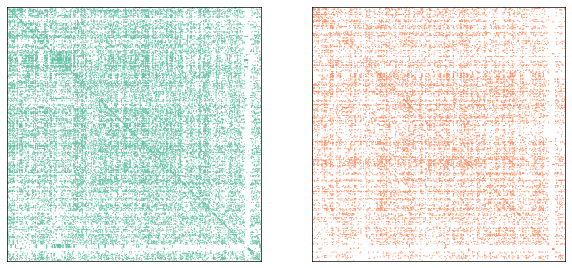

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
adjplot(ipsi_adj, ax=ax, plot_type="scattermap", sizes=(1, 1), color=palette["Ipsi"])
ax = axs[1]
adjplot(
    contra_adj, ax=ax, plot_type="scattermap", sizes=(1, 1), color=palette["Contra"]
)

In [6]:
max_n_components = 40
from giskard.utils import careys_rule

ase = AdjacencySpectralEmbed(n_components=max_n_components)
ipsi_out_latent, ipsi_in_latent = ase.fit_transform(ipsi_adj)
ipsi_singular_values = ase.singular_values_
contra_out_latent, contra_in_latent = ase.fit_transform(contra_adj)
contra_singular_values = ase.singular_values_

<AxesSubplot:title={'center':'Screeplot'}, xlabel='Index', ylabel='Singular value'>

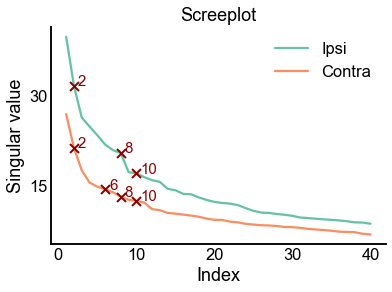

In [7]:
check_n_components = careys_rule(ipsi_adj)
ax = screeplot(
    ipsi_singular_values,
    label="Ipsi",
    color=palette["Ipsi"],
    check_n_components=check_n_components,
)
screeplot(
    contra_singular_values,
    ax=ax,
    label="Contra",
    color=palette["Contra"],
    check_n_components=check_n_components,
)

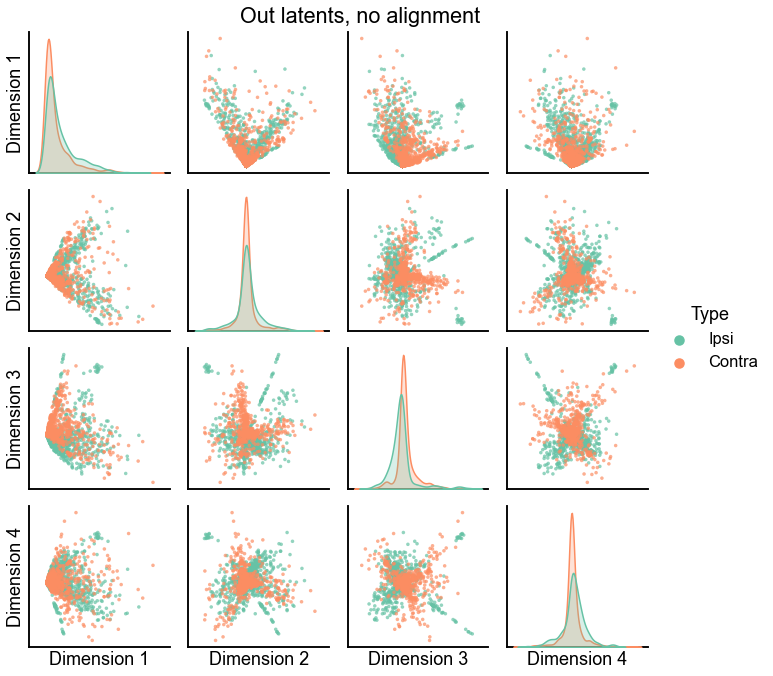

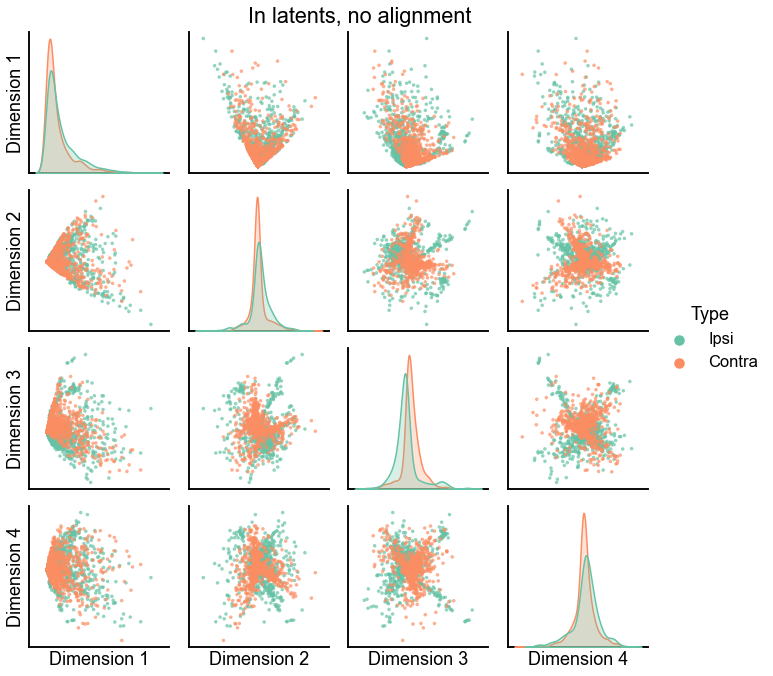

In [8]:


def plot_latents(ipsi, contra, title="", n_show=4):
    plot_data = np.concatenate([ipsi, contra], axis=0)
    labels = np.array(["Ipsi"] * len(ipsi) + ["Contra"] * len(contra))
    pg = pairplot(plot_data[:, :n_show], labels=labels, title=title, palette=palette)
    return pg


plot_latents(ipsi_out_latent, contra_out_latent, title="Out latents, no alignment")

plot_latents(ipsi_in_latent, contra_in_latent, title="In latents, no alignment")

## A modified orthogonal Procrustes procedure
Motivated by the above, we seek to minimize

$$
W^* = \text{argmin}_Q \| B - X W Y^T \|_F^2
$$

$$
\text{argmin}_W \| B - X W Y^T \|_F^2 = \text{argmin}_W \; -2 \langle B, X W Y^T \rangle
$$

which has the same solution as

$$
\text{argmax}_W \; \langle B, X W Y^T \rangle
$$

$$
\langle B, X W Y^T \rangle = tr(B^T X W Y^T) = tr(W Y^T B^T X)
$$

By the Von Neumman trace theorem,

$$
tr(CD) \leq tr(\Sigma_C P \Sigma_D P^T)
$$

Here, we know that the singular values of $W$ are all one, so, letting
$Y^T B^T X = U \Sigma V^T$ be a singular value decomposition,

$$
tr(W Y^T B^T X) \leq tr(\Sigma)
$$

Let $W^* = VU^T$, then

$$
tr(W Y^T B^T X) = tr(V U^T U \Sigma V^T) = tr(\Sigma V^T V) = tr(\Sigma)
$$

Thus, we have achieved the upper bound, and therefore maximized the quantity as desired.

### Implementation
The implementation of the above is quite simple, below is a simple version in numpy.

In [9]:


def inner_procrustes(X, Y, A):
    """Solves argmin over W of \|X W Y^T - A\|_F^2"""
    product = Y.T @ A.T @ X
    U, Sigma, Vt = np.linalg.svd(product, full_matrices=False)
    W = Vt.T @ U.T
    return W

### Test this procrustes
Here, I let:
- $X$ = the estimated ipsilateral out latent positions
- $Y$ = the estimated ipsilateral in latent positions
- $W$ = a matrix sampled uniformly at random from the orthogonal matrices

- $P$ = $X W Y^T$

Then, I estimate $\hat{W}$ using the modified orthogonal Procrustes proceedure
described above. Below I plot the true $\hat{W}$ and the recovered $\hat{W}$, and we
see that they are nearly the same.

In [10]:
from scipy.stats import ortho_group

n_components = 8
W = ortho_group.rvs(n_components)
X = ipsi_out_latent[:, :n_components]
Y = ipsi_in_latent[:, :n_components]
P = X @ W @ Y.T
W_hat = inner_procrustes(X, Y, P)

Frobenius norm of difference in solution: 0.07881005041404328
0.02786356053671184


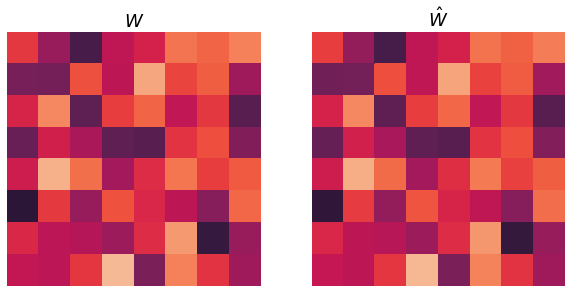

In [11]:
heatmap_kws = dict(
    square=True, vmin=-1, vmax=1, cbar=False, xticklabels=False, yticklabels=False
)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
sns.heatmap(W, ax=ax, **heatmap_kws)
ax.set(title=r"$W$")
ax = axs[1]
sns.heatmap(W_hat, ax=ax, **heatmap_kws)
ax.set(title=r"$\hat{W}$")


diff_norm = np.linalg.norm(W - W_hat, ord="fro")
avg_norm = (np.linalg.norm(W) + np.linalg.norm(W_hat)) / 2
print(f"Frobenius norm of difference in solution: {diff_norm}")
print(diff_norm / avg_norm)

(<AxesSubplot:title={'center':'$\\hat{P}_{contra}$'}>,
 <AxesSubplot:title={'center':'$\\hat{P}_{contra}$'}>,
 <AxesSubplot:title={'center':'$\\hat{P}_{contra}$'}>)

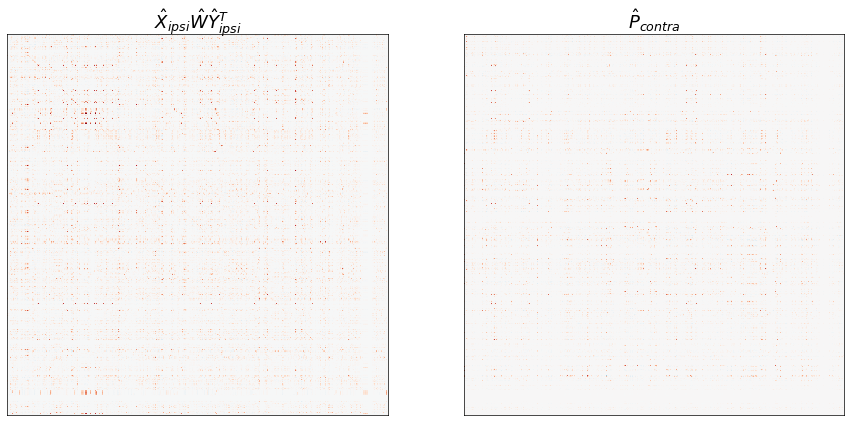

In [12]:
n_components = 16
X_ipsi = ipsi_out_latent[:, :n_components]
Y_ipsi = ipsi_in_latent[:, :n_components]
X_contra = contra_out_latent[:, :n_components]
Y_contra = contra_in_latent[:, :n_components]
W_hat = inner_procrustes(X_ipsi, Y_ipsi, contra_adj)
ipsi_model_P_contra = X_ipsi @ W_hat @ Y_ipsi.T
P_contra = X_contra @ Y_contra.T

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

ax = axs[0]
adjplot(
    ipsi_model_P_contra,
    plot_type="heatmap",
    title=r"$\hat{X}_{ipsi} \hat{W} \hat{Y}_{ipsi}^T$",
    cbar=False,
    ax=ax,
)

ax = axs[1]
adjplot(
    P_contra,
    plot_type="heatmap",
    title=r"$\hat{P}_{contra}$",
    cbar=False,
    ax=ax,
)

In [13]:

from matplotlib.colors import Normalize, SymLogNorm

vmin = -1
vmax = 1
cmap = cm.get_cmap("RdBu_r")
norm = Normalize(vmin, vmax)
norm = SymLogNorm(linthresh=0.1, linscale=2, vmin=vmin, vmax=vmax, base=10)

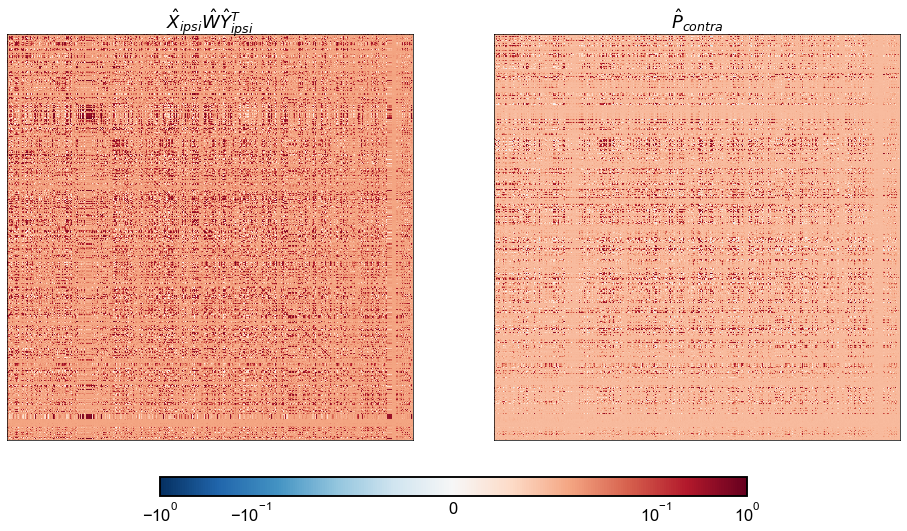

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

adjplot_kws = dict(
    plot_type="heatmap",
    cbar=False,
    cmap=cmap,
    norm=norm,
)

ax = axs[0]
adjplot(
    ipsi_model_P_contra,
    title=r"$\hat{X}_{ipsi} \hat{W} \hat{Y}_{ipsi}^T$",
    ax=ax,
    **adjplot_kws,
)

ax = axs[1]
adjplot(
    P_contra,
    title=r"$\hat{P}_{contra}$",
    ax=ax,
    **adjplot_kws,
)

fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs,
    orientation="horizontal",
    shrink=0.8,
    fraction=0.04,
    aspect=30,
    pad=0.02,
)

In [15]:
diff = ipsi_model_P_contra - P_contra
row_diff_norm = np.linalg.norm(diff, axis=0)
col_diff_norm = np.linalg.norm(diff, axis=1)
mean_diff_norm = (row_diff_norm + col_diff_norm) / 2
sort_inds = np.argsort(mean_diff_norm)[::-1]

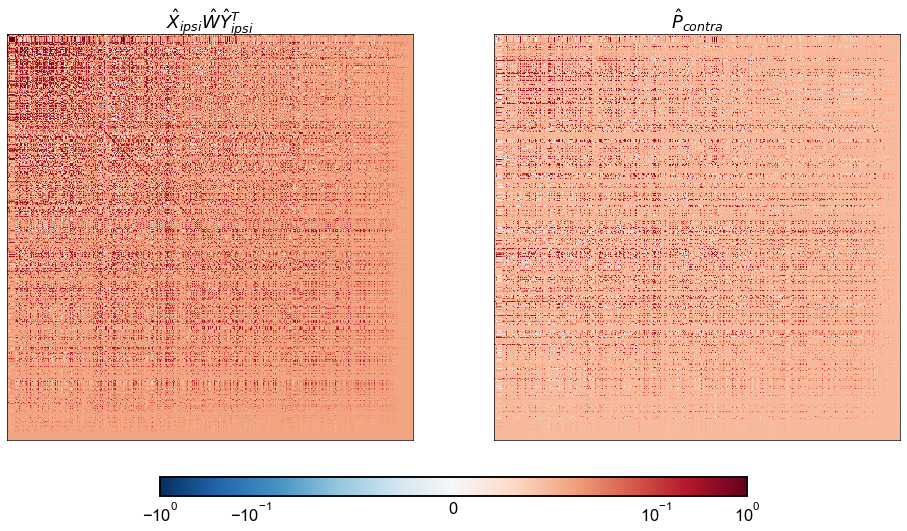

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

ax = axs[0]
adjplot(
    ipsi_model_P_contra[np.ix_(sort_inds, sort_inds)],
    title=r"$\hat{X}_{ipsi} \hat{W} \hat{Y}_{ipsi}^T$",
    ax=ax,
    **adjplot_kws,
)

ax = axs[1]
adjplot(
    P_contra[np.ix_(sort_inds, sort_inds)],
    title=r"$\hat{P}_{contra}$",
    ax=ax,
    **adjplot_kws,
)

fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs,
    orientation="horizontal",
    shrink=0.8,
    fraction=0.04,
    aspect=30,
    pad=0.02,
)
stashfig("contra-model-compare-log-diffsort")

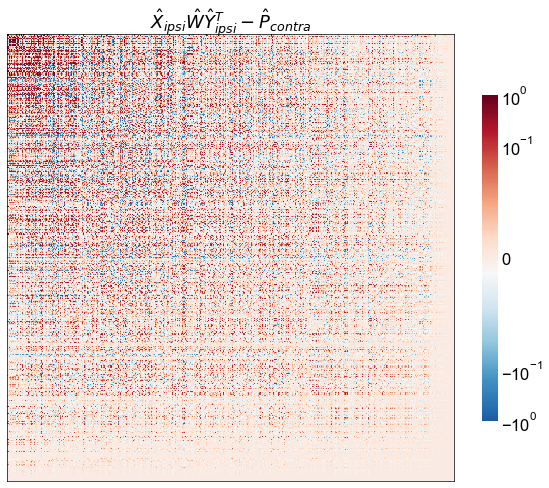

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
adjplot_kws = dict(
    plot_type="heatmap", cbar=True, cmap=cmap, norm=norm, cbar_kws=dict(shrink=0.6)
)
adjplot(
    diff[np.ix_(sort_inds, sort_inds)],
    title=r"$\hat{X}_{ipsi} \hat{W} \hat{Y}_{ipsi}^T - \hat{P}_{contra}$",
    ax=ax,
    **adjplot_kws,
)
stashfig("contra-model-diff-log-diffsort")